# IMDB natural language processing plots

Update the following variables with values corresponding to your own experiments:

In [1]:
# Paths

MODEL_CE_PATH = "../experiments/nlp/logs/lstm/version_0/checkpoints/last.ckpt"
MODEL_LS_PATH = "../experiments/nlp/logs/lstm_ls/version_0/checkpoints/last.ckpt" # LS 06

# Choose your device

DEVICE = "cuda:0"  # or "cpu"

# Whether to save the curve or not

SAVE_IMG = False

Prepare the datamodule and disable gradients:

In [2]:
import torch

from torch_uncertainty_ls.datamodule import IMDBDataModule

# Disable gradients globally
torch.set_grad_enabled(False)

dm = IMDBDataModule(root="../experiments/nlp/data", batch_size=32, num_workers=12)
dm.prepare_data()
dm.setup("test")

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to /home/soumik/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Instantiate the models in memory

In [3]:
from torch_uncertainty.routines import ClassificationRoutine

from torch_uncertainty_ls.lstm_model import LSTMNet

model = LSTMNet()
routine = ClassificationRoutine.load_from_checkpoint(MODEL_CE_PATH, model=model, num_classes=1, loss=None, map_location=DEVICE)

ls_model = LSTMNet()
ls_routine = ClassificationRoutine.load_from_checkpoint(
    MODEL_LS_PATH, model=ls_model, num_classes=1, loss=None, map_location=DEVICE
)

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `FPR95` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Compute the logits for the CE and LS-based models

In [4]:
from tqdm.auto import tqdm

scores = []
logits = []
scores_ls = []
logits_ls = []
correct_samples = []
correct_samples_ls = []

for x, y in tqdm(dm.test_dataloader()[0]):
    x = x.to(DEVICE)
    logit = routine(x)
    logit_ls = ls_routine(x)
    y_hat = logit.sigmoid().cpu().squeeze(-1)
    y_hat_ls = logit_ls.sigmoid().cpu().squeeze(-1)
    score, predicted = torch.max(y_hat, 1 - y_hat), y_hat > 0.5
    score_ls, predicted_ls = torch.max(y_hat_ls, 1 - y_hat_ls), y_hat_ls > 0.5
    correct = predicted == y
    correct_ls = predicted_ls == y
    logits.append(logit)
    logits_ls.append(logit_ls)
    scores.append(score)
    scores_ls.append(score_ls)
    correct_samples.append(correct)
    correct_samples_ls.append(correct_ls)

logits = torch.cat(logits)
logits_ls = torch.cat(logits_ls)
scores = torch.cat(scores)
scores_ls = torch.cat(scores_ls)
correct_samples = torch.cat(correct_samples)
correct_samples_ls = torch.cat(correct_samples_ls)



100%|██████████| 782/782 [00:07<00:00, 108.42it/s]


Compute the coverage curves.

In [5]:
from torch_uncertainty_ls.utils import risk_coverage_curve
ce_risk, ce_cov, thresholds = risk_coverage_curve(correct_samples, scores)
ls_risk, ls_cov, thresholds_ls = risk_coverage_curve(correct_samples_ls, scores_ls)

Plot the AURC, there may be variability but the LS-based model will always have a higher AURC.

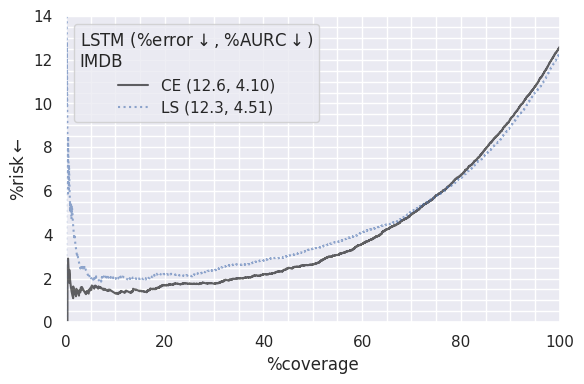

In [6]:
import matplotlib.pyplot as plt
import seaborn

# set the style
seaborn.set_theme()

# Compute and show the risk-coverage curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
    ce_cov * 100,
    ce_risk * 100,
    label=f"CE ({ce_risk[-1]*100:.1f}, {torch.trapz(ce_risk,ce_cov).item()*100:.2f})",
    alpha=0.6,
    color="black",
)
ax.plot(
    ls_cov * 100,
    ls_risk * 100,
    label=f"LS ({ls_risk[-1]*100:.1f}, {torch.trapz(ls_risk, ls_cov).item()*100:.2f})",
    alpha=0.6,
    linestyle="dotted",
)
ax.set_xlabel("%coverage")
ax.set_ylabel("%risk$\leftarrow$")
ax.legend(title="LSTM (%error$\downarrow$, %AURC$\downarrow$)\nIMDB")
ax.grid(visible=True, which="both")
ax.set_xlim(0, 100)
ax.set_ylim(0, 14)
ax.minorticks_on()
fig.tight_layout()

if SAVE_IMG:
    plt.savefig("imdb_aurc.pdf", dpi=300)

plt.show();